In [1]:
import os
import xarray as xr
import numpy as np
from netCDF4 import Dataset
import glob
import torch


# Record the start time
import time
start_time = time.time()

file = 'data_1997_2020_30.nc'
fhadj = Dataset(file, mode='r')


v10 = fhadj.variables['v10'][:]

time = fhadj.variables['tme'][:]
device1 = 'mps'

times,row,col = v10.shape
#v10 = v10.reshape(row,col,times)
print(v10[0][0])


# Convert to PyTorch tensors and move to GPU
v10_gpu = torch.tensor(v10, dtype=torch.float, device=device1)
#time_gpu = torch.tensor(time, dtype=torch.float, device=device1)




[  8.415218    10.302732    11.411515    12.867392    15.077468
  17.748343    20.340557    20.51246     20.175385    21.772303
  23.964148    24.63709     26.160591    29.970133    33.529465
  37.035084    40.99581     44.6379      47.843914    50.27059
  51.078735    49.343487    45.3044      38.51299     30.217981
  22.744434    18.1596      14.992636    12.58687     11.856837
  15.313808    21.11717     25.151503    26.086304    22.505234
  16.330048    11.106776     7.992452     6.807045     6.4883523
   6.1900187    6.179903     5.9333477    5.716011     5.0014887
   4.0070486    3.39502      5.2881827   10.446603    16.871641
  24.98334     28.60531     27.110342    20.06999     11.9964075
   6.155192     5.332082    12.853623    25.52935     41.402946
  59.0822      57.98497     51.48561     32.30356     30.06032
  71.65733    149.0904     161.99739     69.68141     52.934864
  39.49548     20.443756    16.327372    19.774668     7.120318
   7.4153986   33.48558     69.15642   

In [2]:
import torch
import torch.nn.functional as F

def getIndices(x, kernel_size_h, kernel_size_w, stride_h, stride_w):
    indices = {}
    stride = 2
    kernel_size = 2
    h_out = (x.size(0) - kernel_size_h) // stride_h + 1
    w_out = (x.size(1) - kernel_size_w) // stride_w + 1

    for i in range(h_out):
        for j in range(w_out):
            start_i = i * stride_h
            start_j = j * stride_w
            end_i = start_i + kernel_size_h
            end_j = start_j + kernel_size_w

            indices[(i, j)] = [
                (start_i, start_j),               # top-left
                (start_i, end_j-1),               # top-right
                (end_i-1, start_j),               # bottom-left
                (end_i-1, end_j-1)                # bottom-right
            ]

    return indices

def getIndices_in_orginal_gray(row, col, combined_indices):
    indices_list_gray_image = [index for sublist in combined_indices[(row, col)].values() for index in sublist]
    return indices_list_gray_image

def get_combined_indices_on_gpu(x, y, kernel_size_h, kernel_size_w, stride_h, stride_w):
    # Move tensors to GPU
    x_gpu = x.to(device=device1, dtype=torch.float)
    y_gpu = y.to(device=device1, dtype=torch.float)

    # Get indices on GPU
    indices1 = getIndices(x_gpu, kernel_size_h, kernel_size_w, stride_h, stride_w)
    indices2 = getIndices(y_gpu, kernel_size_h, kernel_size_w, stride_h, stride_w)

    print('indices1')
    print(len(indices1))
    print('indices2')
    print(len(indices2))

    # Move data back to CPU
    x_cpu = x_gpu.cpu()
    y_cpu = y_gpu.cpu()

    # Combine indices on CPU
    combined_indices = {}
    for key2, value2 in indices2.items():
        temp_dict = {}
        for idx in value2:
            temp_dict[idx] = indices1[idx]
        combined_indices[key2] = temp_dict

    return combined_indices

x = torch.arange(0, row*col, dtype=torch.float).reshape(row, col)
padded_x = F.pad(x, (1, 1, 1, 1), 'constant', 0)

# Applying average pooling
y = F.avg_pool2d(padded_x.unsqueeze(0).unsqueeze(0), kernel_size=(2, 2), stride=(2, 2)).squeeze()
y_output = F.avg_pool2d(y.unsqueeze(0).unsqueeze(0), kernel_size=(2, 2), stride=(2, 2)).squeeze()

# Get combined indices on GPU
combined_indices_gpu = get_combined_indices_on_gpu(padded_x, y, 2, 2, 2, 2)



# Example usage on GPU
print(len(getIndices_in_orginal_gray(2, 3, combined_indices_gpu)))
print(getIndices_in_orginal_gray(0, 0, combined_indices_gpu))


indices1
7381
indices2
1800
16
[(0, 0), (0, 1), (1, 0), (1, 1), (0, 2), (0, 3), (1, 2), (1, 3), (2, 0), (2, 1), (3, 0), (3, 1), (2, 2), (2, 3), (3, 2), (3, 3)]


In [3]:
import pandas as pd
import numpy as np
import torch

def getKernel(input):
    # Move input data to GPU
    #input_gpu = torch.tensor(input, dtype=torch.float, device=device1).clone().detach()

    result_df = torch.ones((2, 2))
    result_df_gpu = result_df.clone().detach().to(device=device1, dtype=torch.float)

    return result_df_gpu




In [4]:
import torch

def get_diff_gray_image_kernel_list_gpu(gray_image_list):
    diff_gray_image_list = []
    diff_gray_image_kernel_list_2_2 = []

    for i in range(len(gray_image_list)):
        # Move data to GPU
        arr_gpu = torch.tensor(gray_image_list[i], dtype=torch.float, device=device1).clone().detach()

        # Convert back to NumPy for further processing
        arr = arr_gpu #.cpu().numpy()
        diff_gray_image_list.append(arr)

        # Assuming getKernel is a function that also supports GPU
        kernel_arr_gpu = getKernel(arr_gpu)
        kernel_arr = kernel_arr_gpu #.clone().detach().cpu().numpy()
        diff_gray_image_kernel_list_2_2.append(kernel_arr)

    return diff_gray_image_list, diff_gray_image_kernel_list_2_2



import torch
import torch.nn as nn
import numpy as np

def apply_3x3_sharpening(input_tensor, kernel):
    input_tensor = input_tensor.unsqueeze(0).unsqueeze(0).float().to(device1)
    kernel_tensor = kernel.unsqueeze(0).unsqueeze(0).float().to(device1)

    kernel_row, kernel_col = len(kernel_tensor), len(kernel_tensor[0])

    conv_layer = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=(kernel_row, kernel_col), stride=(2, 2), padding=1, bias=False).to(device1)
    conv_layer.weight.data = kernel_tensor

    output = conv_layer(input_tensor)

    return output[0, 0].detach().cpu().numpy()

def get_kernel_applied_result_in_diff_gray_image_gpu(diff_gray_image_list, diff_gray_image_kernel_list_2_2):
    kernel_applied_result_in_diff_gray_image = []

    for i in range(len(diff_gray_image_list)):
        matrix = diff_gray_image_list[i].clone().detach()
        kernel = diff_gray_image_kernel_list_2_2[i].clone().detach()

        result = apply_3x3_sharpening(matrix, kernel)
        kernel_applied_result_in_diff_gray_image.append(result)

    return kernel_applied_result_in_diff_gray_image



In [5]:
import torch

def truncating_array_83_79_gpu(original_array):
    # Convert the NumPy array to a PyTorch tensor and move it to GPU
    original_tensor = torch.tensor(original_array).float().to(device1)

    # Define the pooling parameters
    pool_size = (2, 2)
    stride = 2

    # Calculate the dimensions of the output tensor
    output_height = (original_tensor.shape[1] - pool_size[0]) // stride + 1
    output_width = (original_tensor.shape[2] - pool_size[1]) // stride + 1

    # Initialize the output tensor on GPU
    output_tensor = torch.zeros((original_tensor.shape[0], output_height, output_width, 4), device=device1)

    # Apply 2x2 average pooling with a stride of 2
    for i in range(output_height):
        for j in range(output_width):
            # Define the pooling region
            region = original_tensor[:, i * stride:i * stride + pool_size[0], j * stride:j * stride + pool_size[1]]
            # Reshape the region to a (4,) tensor and store it in the output tensor
            output_tensor[:, i, j] = region.reshape(-1, 4)

    # Move the output tensor back to CPU and convert it to a NumPy array
    reshaped_data = output_tensor.detach().cpu().numpy()

    return reshaped_data

# Assuming device1 is defined earlier
device1 = 'mps'



In [6]:
import torch

# Assuming 'gray_image_list' is a list of NumPy arrays
gray_image_list_gpu = v10_gpu



#kernel_applied_result_in_diff_gray_image_overall =  []

def get_diff_gray_image_kernel_list_gpu(gray_image_list):
    diff_gray_image_list = []
    diff_gray_image_kernel_list_2_2 = []

    for i in range(len(gray_image_list)):
        # Move data to GPU
        arr_gpu = gray_image_list[i]

        # Convert back to NumPy for further processing
        arr = arr_gpu   #. cpu().numpy()
        diff_gray_image_list.append(arr)

        # Assuming getKernel is a function that also supports GPU
        kernel_arr_gpu = getKernel(arr_gpu)
        kernel_arr = kernel_arr_gpu #.cpu().numpy()
        diff_gray_image_kernel_list_2_2.append(kernel_arr)

    return diff_gray_image_list, diff_gray_image_kernel_list_2_2


diff_gray_image_list_gpu, diff_gray_image_kernel_list_2_2_gpu = get_diff_gray_image_kernel_list_gpu(gray_image_list_gpu)

# Assuming 'get_kernel_applied_result_in_diff_gray_image' is a function you have defined
temp_arr_gpu = get_kernel_applied_result_in_diff_gray_image_gpu(diff_gray_image_list_gpu, diff_gray_image_kernel_list_2_2_gpu)



non_zero_values_gpu = temp_arr_gpu

# Append the GPU results to the overall list
kernel_applied_result_in_diff_gray_image_overall = non_zero_values_gpu


/var/folders/1f/9_2wggdd2ygfkk69t5zj8cyh0000gr/T/ipykernel_5524/3840120727.py:5: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  original_tensor = torch.tensor(original_array).float().to(device1)


1.5
1.5


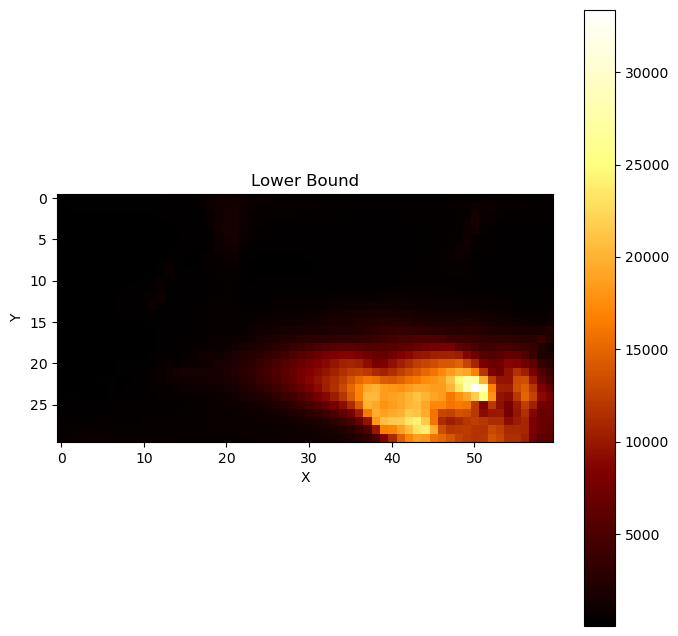

In [7]:


import numpy as np
import glob
import datetime
from datetime import date
from datetime import timedelta
# import datetime
# from dateutil.relativedelta import relativedelta
# from datetime import datetime
# import pandas as pd
import os
from netCDF4 import Dataset
import netCDF4 as nc
import xarray as xr
# from osgeo import gdal
# import geopandas as gpd
# from shapely.geometry import MultiPolygon, Polygon, Point
# from scipy import io
import pandas as pd
from scipy.stats import iqr

new_x= truncating_array_83_79_gpu(kernel_applied_result_in_diff_gray_image_overall)

row1, col1 = int(row/4), int(col/4)
intial = 15
#for kk in np.arange(1.5, , 0.1):
kk = 1.5
print(kk)

import torch
import torch.nn as nn
import numpy as np

# Assuming new_x is already on GPU
x = torch.tensor(new_x, dtype=torch.float, device=device1)


initial = 15
kk = 1.5
print(kk)

lower_bound, q1_for_future_use = torch.zeros((row1, col1), device=device1), torch.zeros((row1, col1), device=device1)

for i in range(row1):
    for j in range(col1):
        q1 = torch.quantile(x[:, i, j, :], 0.25)
        q3 = torch.quantile(x[:, i, j, :], 0.75)
        lb = q3 + kk * (q3 - q1)
        lower_bound[i, j] = lb
        q1_for_future_use[i, j] = q3

# Save results
np.savetxt('lb' + str(initial) + '.txt', lower_bound.cpu().numpy(), delimiter='\t', fmt='%.4f')
np.savetxt('q1' + str(initial) + '.txt', q1_for_future_use.cpu().numpy(), delimiter='\t', fmt='%.4f')

initial += 1

# Create a figure and axis
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 8))

# Display the 2D matrix as an image
im = ax.imshow(q1_for_future_use.cpu().numpy(), cmap='afmhot')  # You can change the colormap to your preference

# Add a colorbar to the plot (optional)
cbar = fig.colorbar(im, ax=ax)

# Set labels and title (optional)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_title('Lower Bound')

# Show the plot
plt.show()



In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

device1 = 'mps'

def pooling(input_matrix, pool_height, pool_width, stride_height, stride_width, pool_type):
    if pool_type == 'max':

        input_matrix1 = torch.tensor(input_matrix, device=device1)  # Move to GPU

        input_tensor = input_matrix1.unsqueeze(0).unsqueeze(0)

        max_pool = nn.MaxPool2d(kernel_size=(pool_height, pool_width), stride=(stride_height, stride_width))

        return_max = max_pool(input_tensor)[0][0] #.cpu().detach().numpy()
        return  return_max

    elif pool_type == 'mean':
        input_tensor = torch.tensor(input_matrix, device=device1)
        input_tensor = input_tensor.unsqueeze(0).unsqueeze(0)

        mean_pool = nn.AvgPool2d(kernel_size=(pool_height, pool_width), stride=(stride_height, stride_width))

        return mean_pool(input_tensor)[0][0] #.cpu().detach().numpy()

In [ ]:

def optimalSolution(matrix, total_std, main_folder, q1, which_constant, index=0):
    r, c = 2, 2

    filename1 = time[index]
    print(filename1[0:4])

    folder = main_folder + '/' + '-' + str(filename1[0:4])

    if not os.path.exists(folder):
        os.makedirs(folder)

    folder = folder + '/'

    max_pooled = pooling(matrix, pool_height=r, pool_width=c, stride_height=r, stride_width=c, pool_type='max')
    mean_pooled = pooling(matrix, pool_height=r, pool_width=c, stride_height=r, stride_width=c, pool_type='mean')

    row, col = max_pooled.shape

    filename_extension = folder + str(r) + str('x') + str(c) + '_' + str(which_constant) + '_' + str(filename1)

    # Rest of your GPU code (anomaly_discord_array, hh_array, ss_array) goes here

    # Convert max_pooled and mean_pooled to PyTorch tensors on GPU
    max_pooled_gpu = max_pooled
    mean_pooled_gpu = mean_pooled

    #################### anomaly discord ##################################################
    saveFile = False

    anomaly_discord_array = torch.zeros((123, 243), device=device1)
    gray_orginal_array = v10_gpu[index]
    anomaly_discord_all_row_col_list = []

    for i in range(row):
        for j in range(col):
            if max_pooled_gpu[i][j] > total_std[i][j]:
                if mean_pooled_gpu[i][j] / max_pooled_gpu[i][j] > q1[i][j] / total_std[i][j]:
                    getIndices_anomaly = getIndices_in_orginal_gray(i, j,combined_indices_gpu)
                    anomaly_discord_all_row_col_list.append(getIndices_anomaly)
                    saveFile = True

    for iii in range(len(anomaly_discord_all_row_col_list)):
        iterativeList = anomaly_discord_all_row_col_list[iii]
        for item in iterativeList:
            rowIndex, colIndex = item
            anomaly_discord_array[rowIndex, colIndex] = gray_orginal_array[rowIndex, colIndex]

    anomaly_discord_array = anomaly_discord_array[1:-1, 1:-1]
    np.savetxt(filename_extension + str('_anomaly_discord') + '.txt', anomaly_discord_array.cpu().numpy(), delimiter='\t', fmt='%d')

    ################################# original hh ###########################################

    saveFile = False

    hh_array = torch.zeros((143, 243), device=device1)
    hh_all_row_col_list = []
    counter = 0

    for i in range(row):
        for j in range(col):
            if max_pooled_gpu[i][j] > total_std[i][j]:
                if mean_pooled_gpu[i][j] / max_pooled_gpu[i][j] > q1[i][j] / total_std[i][j]:
                    counter += 1
                    getIndices_hh = getIndices_in_orginal_gray(i, j,combined_indices_gpu)
                    hh_all_row_col_list.append(getIndices_hh)
                    saveFile = True

    for iii in range(len(hh_all_row_col_list)):
        iterativeList = hh_all_row_col_list[iii]
        for item in iterativeList:
            rowIndex, colIndex = item
            hh_array[rowIndex, colIndex] = gray_orginal_array[rowIndex, colIndex]

    hh_array = hh_array[1:-1, 1:-1]
    #np.savetxt(filename_extension + str('_hh') + '.txt', hh_array.cpu().numpy(), delimiter='\t', fmt='%d')

    ################################# original ss ###########################################

    saveFile = False

    ss_array = torch.zeros((143, 243), device=device1)
    ss_all_row_col_list = []
    counter = 0

    for i in range(row):
        for j in range(col):
            if 0 < mean_pooled_gpu[i][j] < q1[i][j]:
                counter += 1
                getIndices_ss = getIndices_in_orginal_gray(i, j, combined_indices_gpu)
                ss_all_row_col_list.append(getIndices_ss)
                saveFile = True

    for iii in range(len(ss_all_row_col_list)):
        iterativeList = ss_all_row_col_list[iii]
        for item in iterativeList:
            rowIndex, colIndex = item
            ss_array[rowIndex, colIndex] = gray_orginal_array[rowIndex, colIndex]

    ss_array = ss_array[1:-1, 1:-1]
    #np.savetxt(filename_extension + str('_ss') + '.txt', ss_array.cpu().numpy(), delimiter='\t', fmt='%d')





iterator = 0


folder_holder = 'anomaly_discord_'

if not os.path.exists(folder_holder):
    print('I am here')
    os.makedirs(folder_holder)

kkkk = 15
total_std = torch.tensor(np.loadtxt('lb' + str(kkkk) + '.txt'), dtype=torch.float, device=device1)
q1 = torch.tensor(np.loadtxt('q1' + str(kkkk) + '.txt'), dtype=torch.float, device=device1)
for i in range(len(kernel_applied_result_in_diff_gray_image_overall)):
    matrix = kernel_applied_result_in_diff_gray_image_overall[i]
    #print(i)



    optimalSolution(matrix, total_std, folder_holder, q1, kkkk, i)


In [ ]:
import time



end_time = time.time()

# Calculate the elapsed time
elapsed_time = end_time - start_time

print(f"Elapsed time: {elapsed_time} seconds")

we are complete 0
Elapsed time: 1638.8520860671997 seconds


In [ ]:
print(row,col)

121 241


In [ ]:
########################## Below code are auxilary function####################################
########################## Below code are auxilary function####################################
########################## Below code are auxilary function####################################

########################## Below code are auxilary function####################################
########################## Below code are auxilary function####################################
########################## Below code are auxilary function####################################


########################## Below code are auxilary function ####################################
########################## Below code are auxilary function ####################################

In [ ]:
# import numpy as np

# # Sample padded array (334x318)
# padded_array = np.random.randint(0, 10, (334, 318))  # Creating a random array for demonstration purposes

# print("Padded array shape:", padded_array.shape)
# print(padded_array)

# # Removing the padding by indexing
# unpadded_array = padded_array[1:-1, 1:-1]

# print("Unpadded array shape:", unpadded_array.shape)
# print(unpadded_array)

